In [6]:
import pandas
import seaborn
import numpy

# TODO: ADD CORRELATION FOR TYPE OF HOME, DROP ZIPCODE

data_orig = pandas.read_csv('austinHousingData.csv')
data_orig.info()

labelsToRemove = ['zpid', 'city', 'streetAddress', 'latitude', 'longitude', 'description', 'hasGarage', 'numPriceChanges', 'latest_saledate', 'latest_salemonth', 'latest_saleyear', 'latestPriceSource', 'numOfPhotos', 'homeImage']

data_orig.drop(labelsToRemove, axis=1, inplace=True)

data_raw = data_orig.select_dtypes(exclude=['object'])

floatColumns = numpy.asarray(data_raw.select_dtypes(include=['float64']).columns).tolist()
boolColumns = numpy.asarray(data_raw.select_dtypes(include=['bool']).columns).tolist()
intColumns = numpy.asarray(data_raw.select_dtypes(include=['int64']).columns).tolist()

floatData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), data_raw.drop(boolColumns + intColumns, axis=1), right_index=True, left_index=True)
boolData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), data_raw.drop(floatColumns + intColumns, axis=1), right_index=True, left_index=True)
intData = data_raw.drop(boolColumns + floatColumns, axis=1)
intData.drop(['zipcode'], axis=1, inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

Heatmap for Float64 values and latestPrice


<AxesSubplot:>

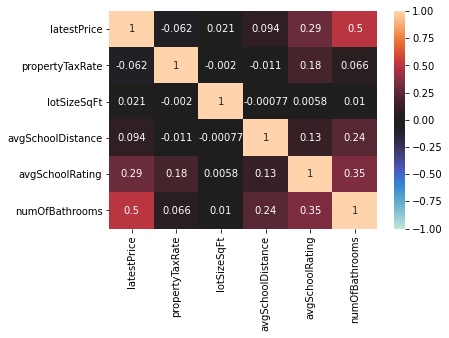

In [7]:
print("Heatmap for Float64 values and latestPrice")
seaborn.heatmap(floatData.corr(), vmin=-1, vmax=1, center=0, annot=True)

Here we see that numOfBathrooms has the highest correlation with price of .5

Heatmap for bool values and latestPrice


<AxesSubplot:>

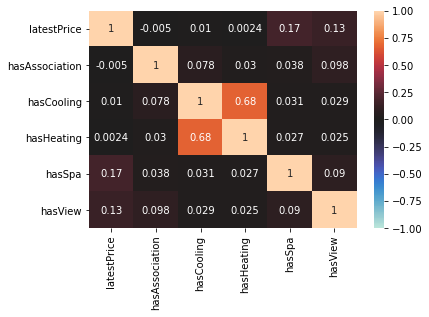

In [8]:
print("Heatmap for bool values and latestPrice")
seaborn.heatmap(boolData.corr(), vmin=-1, vmax=1, center=0, annot=True)


Here we see that none of these are particularly noteworthy, with hasSpa having the highest correlation of .17

Heatmap for int values and latestPrice


<AxesSubplot:>

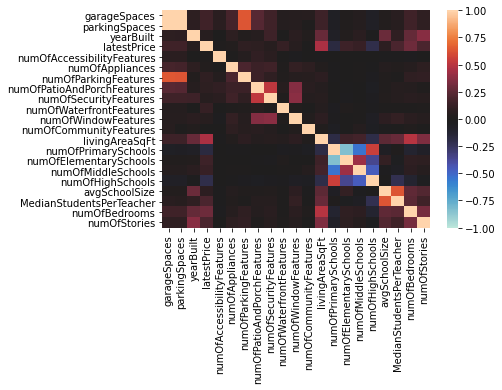

In [9]:

print("Heatmap for int values and latestPrice")
seaborn.heatmap(intData.corr(), vmin=-1, vmax=1, center=0, annot=False, xticklabels=True, yticklabels=True)

On quick look, we see that yearBuilt,  numOfParkingFeatures, numOfPatioAndPorchFeatures, numOfSecurityFeatures, numOfWindowFeatures, numOfCommunityFeatures, avgSchoolSize all have zero correlation to latestPrice, so we remove them to have an easier view of the data.

We see that numOfAccessibilityFeatures, numOfAppliances both don't have correlation so we remove them

In [11]:
dropLabels = ['numOfAccessibilityFeatures', 'numOfAppliances', 'yearBuilt', 'numOfParkingFeatures', 'numOfPatioAndPorchFeatures', 'numOfSecurityFeatures', 'numOfWindowFeatures', 'numOfCommunityFeatures', 'avgSchoolSize']
intDataNew = intData.drop(dropLabels, axis=1)



<AxesSubplot:>

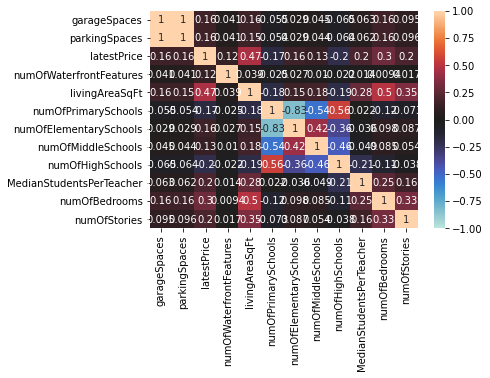

In [12]:
seaborn.heatmap(intDataNew.corr(), vmin=-1, vmax=1, center=0, annot=True, xticklabels=True, yticklabels=True)

Here we can see that livingAreaSqFt has the highest correlation of 0.47. The other closest correlations are 0.3 for numOfBedrooms, -0.2 for numOfHighSchools, and 0.2 for medianStudentPerTeacher.  

<AxesSubplot:>

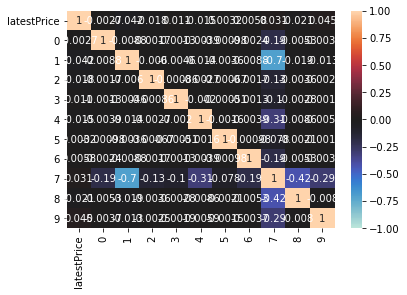

In [13]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

onehotEncoder = OneHotEncoder(sparse=False)
homeTypeEncoded = data_orig.homeType.values.ravel()
homeTypeEncoded = homeTypeEncoded.reshape(len(homeTypeEncoded), 1)
onehotHomeTypeEncoded = onehotEncoder.fit_transform(homeTypeEncoded)
homeTypeDataframe = pandas.DataFrame(onehotHomeTypeEncoded)

homeTypeData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), homeTypeDataframe, right_index=True, left_index=True)

seaborn.heatmap(homeTypeData.corr(), vmin=-1, vmax=1, center=0, annot=True, xticklabels=True, yticklabels=True)

As we can see here, there is close to zero correlation between home type and latestPrice.

In [15]:
from sklearn.preprocessing import OneHotEncoder

onehotEncoder = OneHotEncoder(sparse=False)
zipEncoded = data_orig.zipcode.values.ravel()
zipEncoded = zipEncoded.reshape(len(zipEncoded),1)
onehotZipEncoded = onehotEncoder.fit_transform(zipEncoded)
zipDataframe = pandas.DataFrame(onehotZipEncoded)

zipData = pandas.merge(pandas.DataFrame(data_raw.latestPrice), zipDataframe, right_index=True, left_index=True)


savedIndexes = []

index = 0
for x in zipData.corr().values[0]:
    if x >= .2 and x != 1:
        print("Correlation:", x, ", index:", index)
        savedIndexes.append(index)
    index += 1

added = []

inverse = onehotEncoder.inverse_transform(onehotZipEncoded)
for i in range(0,len(onehotZipEncoded)):
    if onehotZipEncoded[i][8] == 1 or onehotZipEncoded[i][36] == 1:
        if not inverse[i] in added:
            added.append(inverse[i][0])

print(added)

Correlation: 0.21369954968195284 , index: 8
Correlation: 0.2289823565636024 , index: 36
[78747, 78704]


The code above shows that we have a little correlation between zipcode and the price when the zipcode is 78747 or 78704. This correlation is pretty low for only two zip codes, however. I do not recommend we use this for the regression.

**From this data, we can see that the fields that are most impactful are livingAreaSqFt, numOfBathrooms, avgSchoolRating, numOfBedrooms, numOfHighSchools, and medianStudentPerTeacher**